In [1]:
import requests
import sqlalchemy
import pymysql
import pandas as pd

In [2]:
endpoint = "web-users.czjoi0srhr5i.eu-west-3.rds.amazonaws.com"
password = "Grupo2AWS"
user = "admin"

In [3]:
db = pymysql.connect(host = endpoint,
                     user = user,
                     password = password,
                     cursorclass = pymysql.cursors.DictCursor
)

In [4]:
cursor = db.cursor()

In [5]:
engine = sqlalchemy.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(user = user, pw = password, host = endpoint, db = 'users_web_db'))

In [6]:
query = """select * from users_web"""

In [7]:
data = pd.read_sql(query, con=engine)

In [8]:
data.date = pd.to_datetime(data.date, dayfirst=True)
data.set_index('date')

,users,prediccion
date,,
2020-01-01,13,None
2020-01-02,17,None
2020-01-03,13,None
2020-01-04,4,None
2020-01-05,10,None
...,...,...
2022-04-26,63,None
2022-04-27,64,None
2022-04-28,46,None


In [9]:
data = data.drop(columns='prediccion')

In [10]:
data.date = pd.to_datetime(data.date)

In [11]:
data = data.drop_duplicates(keep='last')

In [12]:
data =data.set_index('date').asfreq('D')

In [13]:
weekly = data.groupby(pd.Grouper(freq='W')).sum()

In [14]:
train_data = weekly[:-4]
train_data

,users
date,
2020-01-05,57
2020-01-12,159
2020-01-19,147
2020-01-26,211
2020-02-02,760
...,...
2022-03-06,292
2022-03-13,337
2022-03-20,370


In [15]:
test_data = weekly[-4:]

In [16]:
test_data

,users
date,
2022-04-10,367
2022-04-17,297
2022-04-24,358
2022-05-01,288


Mi tabla train (datos presentes)

In [17]:
train_data

,users
date,
2020-01-05,57
2020-01-12,159
2020-01-19,147
2020-01-26,211
2020-02-02,760
...,...
2022-03-06,292
2022-03-13,337
2022-03-20,370


Mi tabla datos futuros

In [18]:
test_data

,users
date,
2022-04-10,367
2022-04-17,297
2022-04-24,358
2022-05-01,288


In [20]:
from funcs import *

In [24]:
def do_train(data):
    """Comprobar el MAPE y hacer retrain con autoarima si el mayor de 0.2"""
    data.Date = pd.to_datetime(data.date, dayfirst=True)
    data = data.set_index('date')
    weekly = data.groupby(pd.Grouper(freq='W')).sum()
    arima = AutoARIMA(start_p = 1, start_q = 1)
    arima.fit(weekly)
    with open('arima.pickle', 'wb') as f:
        pickle.dump(arima, f)
    return "refit done"
    

In [25]:
do_train(train_data.reset_index())

C:\Users\fpala\AppData\Local\Temp\ipykernel_11756\2126283275.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.Date = pd.to_datetime(data.date, dayfirst=True)
c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converg

'refit done'

In [26]:
predicciones = do_predict(4)

c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sktime\forecasting\base\_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


In [28]:
train_data

,users
date,
2020-01-05,57
2020-01-12,159
2020-01-19,147
2020-01-26,211
2020-02-02,760
...,...
2022-03-06,292
2022-03-13,337
2022-03-20,370


In [53]:
mask = data.index > '2022-04-03'
new_data = data[mask]
present_data = data[~mask]

In [42]:
new_data

,users
date,
2022-04-04,86
2022-04-05,56
2022-04-06,53
2022-04-07,48
2022-04-08,55
2022-04-09,37
2022-04-10,32
2022-04-11,61
2022-04-12,46


In [ ]:
predicciones

,users
2022-04-10,353.765895
2022-04-17,332.296334
2022-04-24,316.349741
2022-05-01,304.505352


In [49]:
real = new_data.groupby(pd.Grouper(freq='W')).sum().loc['2022-04-10']

In [50]:
prediccion = predicciones.loc[['2022-04-17']]

In [51]:
mean_absolute_percentage_error(y_true=real.values, y_pred=prediccion.values)

0.11884287465359263

In [55]:
new_present_data = pd.concat([present_data, new_data])

In [ ]:
# ver la ultima fecha que ha entrado en la tabla new data
# ver si esta en predicciones
    # si esta: calcular la suma de la semana, y el MAPE:
            # si el mape es > 0.2
            #   -> retrain y predict y append
            # si no, nada
    # si no esta: nada

<AxesSubplot:xlabel='date'>

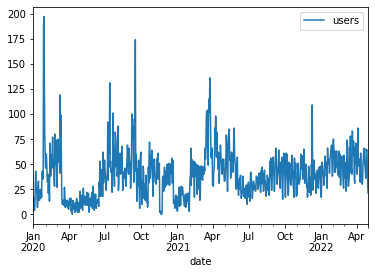

In [62]:
new_present_data.plot()

In [58]:
do_train(new_present_data.reset_index())

C:\Users\fpala\AppData\Local\Temp\ipykernel_11756\2126283275.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.Date = pd.to_datetime(data.date, dayfirst=True)
c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converg

'refit done'

In [61]:
new_present_data

,users
date,
2020-01-01,13
2020-01-02,17
2020-01-03,13
2020-01-04,4
2020-01-05,10
...,...
2022-04-26,63
2022-04-27,64
2022-04-28,46


In [60]:
do_predict(1)

c:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\sktime\forecasting\base\_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


,users
2022-05-08,290.818961


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
data.to_sql()